In [1]:
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 
from progressbar import ProgressBar
pbar = ProgressBar() 

### Step 1: Define Model Analysis

In [2]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}

In [3]:
def Truss_solver(nodes, elements, supports, forces, elasticity, areas):
    cross_area = {1:areas[0], 2:areas[1], 3:areas[2], 4:areas[3], 5:areas[4],
                  6:areas[5], 7:areas[6], 8:areas[7], 9:areas[8], 10:areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_, Ten_Bar_Truss_Case_1.displacements_)

#### Step 2: Define Objective Function

In [4]:
def Objective_Function(areas):    
    member_lengths, member_stresses, node_displacements = Truss_solver(nodes, elements, supports, forces, elasticity, areas)    
    total_area = np.array(areas)
    
    total_member_lengths = []
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    weight = weight.sum() * 0.1 # lb/in^3

    return (weight, member_stresses, node_displacements)

#### Step 3: Define Constraints

In [5]:
def stress_constraint(stress_new):
    if stress_new > 25 or stress_new < -25:
        stress_counter = 1
    else:
        stress_counter = 0
    
    return stress_counter

In [6]:
def displacement_constraint(node_displacement_new):    
    x = node_displacement_new[0]
    y = node_displacement_new[1]
    if x > 2 or x < -2:
        displacement_counter = 1
    elif y > 2 or y < -2:
        displacement_counter = 1
    else:
        displacement_counter = 0

    return displacement_counter

### Step 4: Define Algorithm

Step 4.1: Initialize Parameters

In [7]:
D = [1.62, 1.80, 1.99, 2.13, 2.38, 2.62, 2.63, 2.88, 2.93, 3.09,
     3.13, 3.38, 3.47, 3.55, 3.63, 3.84, 3.87, 3.88, 4.18, 4.22,
     4.49, 4.59, 4.80, 4.97, 5.12,5.74, 7.22, 7.97, 11.50, 13.50, 
     13.90, 14.20, 15.50, 16.00, 16.90, 18.80, 19.90, 22.00, 22.90, 
     26.50, 30.00, 33.50]

In [8]:
def closest(list_of_areas, area_values_list):
    for i, area_value in enumerate(area_values_list):
        idx = (np.abs(list_of_areas - area_value)).argmin() 
        area_values_list[i] = list_of_areas[idx]
    return area_values_list

In [9]:
# Initialize Wolves
alpha_position = 2
alpha_score = float("inf")

beta_position = 23
beta_score = float("inf")

delta_position = 40
delta_score = float("inf")

# Initialize No. of Wolves (Search Agents)
search_agents = 100

# Total Number of Iterations
max_iterations = 1000

# Initialize Random Location of No. of Wolves (Search Agents)
positions = np.empty([search_agents, len(elements)])
for row in range(search_agents):
    for i in range(len(positions[0])):
        positions[row,i] = np.random.choice(D)

In [10]:
best_alpha_score = []
best_alpha_positions = []
best_beta_positions = []
best_delta_positions = []
positions_old = positions

### Step 4.2: Grey Wolf Algorithm

In [11]:
%%time

for m in range(0, max_iterations):
    for i in range(0, search_agents):

        # Return back the search agents that go beyond the boundaries of the search space
        # for j in range(search_agents):
        #     positions[i]=np.clip(positions[i], lb, ub)

        # Calculate objective function for each search agent
        fitness, stresses_new, node_displacement_new = Objective_Function(positions[i])

        # Constraint 1: stresses should be within 25ksi and -25ksi
        for j in stresses_new:
            stress_counter = stress_constraint(stresses_new[j])

        # Constraint 2: Node Displacement should be limited to -2in and 2in
        displacement_counter = 0
        for k in node_displacement_new:
            displacement_counter = displacement_counter + displacement_constraint(node_displacement_new[k])

        if displacement_counter == 0 and stress_counter == 0:    
            if fitness < alpha_score:
                alpha_score = fitness
                alpha_position = positions[i].copy()
            if (fitness > alpha_score and fitness < beta_score):
                beta_score = fitness
                beta_position = positions[i].copy()
            if (fitness > alpha_score and fitness > beta_score and fitness < delta_score):
                delta_score = fitness
                delta_position = positions[i].copy()
        else:
            alpha_position = alpha_position
            beta_position = beta_position
            delta_position = delta_position

    a = 2 - m*(2/max_iterations)

    for i in range(0,search_agents):
        # compute distance of alpha
        r1 = random()
        r2 = random()

        a1 = 2*a*r1-a
        c1 = 2*r2

        distance_alpha = abs(c1*alpha_position-positions[i])
        x1 = alpha_position - a1*distance_alpha

        # compute distance of beta        
        r1 = random()
        r2 = random()

        a2 = 2*a*r1-a
        c2 = 2*r2

        distance_beta = abs(c2*beta_position-positions[i])
        x2 = beta_position - a2*distance_beta

        # compute distance of delta        
        r1 = random()
        r2 = random()

        a3 = 2*a*r1-a
        c3 = 2*r2

        distance_delta = abs(c3*delta_position-positions[i])
        x3 = delta_position - a3*distance_delta

        # in the middle (average) of the 3 wolf's distance (encircle), the prey is found
        positions[i] = (x1 + x2 + x3) / 3
        closest(D, positions[i])
    
    positions_old = positions.copy()

    best_alpha_score.append(alpha_score)

Wall time: 2min 13s


## Plots and Results

### Convergence Graph

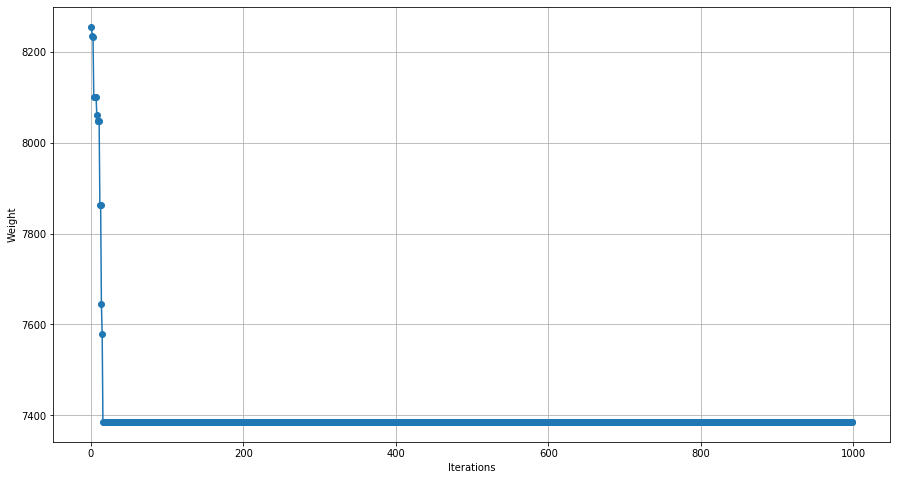

In [12]:
plt.figure(figsize=[15,8])
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Weight')
plt.plot(best_alpha_score, marker = 'o')

## Check Solution of Optimization

In [13]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key+1: positions[-1][key] for key in range(10)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [14]:
Ten_Bar_Truss_Case_1.displacements_

{1: [0.49146, -1.89072],
 2: [-0.39932, -1.99256],
 3: [0.38962, -0.83472],
 4: [-0.24958, -0.86166],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}

In [15]:
Ten_Bar_Truss_Case_1.member_stresses_

{1: 10.82278,
 2: 2.82889,
 3: -6.93278,
 4: -4.15944,
 5: 0.74833,
 6: 2.82889,
 7: 8.50111,
 8: -6.18194,
 9: 5.12361,
 10: -4.00028}

In [16]:
cross_area

{1: 15.5,
 2: 15.5,
 3: 33.5,
 4: 13.5,
 5: 15.5,
 6: 15.5,
 7: 22.0,
 8: 15.5,
 9: 15.5,
 10: 15.5}

In [17]:
weight, _, _ = Objective_Function(positions[0])
weight

7411.450644812052